# Tarea 03: Árboles de decisión

En la carpeta de data https://github.com/scidatmath2020/ML_Py_23/tree/main/data encontrarás la tabla datos_iris.csv. Aplica árboles de decisión para clasificar la variable Species. Recuerda que la variable objetivo NO DEBE SER CONVERTIDA A VARIABLES DUMMIES. 

¿Crees que se trate de clases balanceadas o desbalanceadas? Recuerda que en el tema de regresión logística vimos cómo contar los elementos de cada clase mediante group_by de siuba y la función n(_) de siuba.dply.vector. 

En términos de profunidad, ¿con cuántas preguntas se maximiza el roc_auc?

In [1]:
# Importamos las librerías estandar para manipular nuestro dataframe
import os
import pandas as pd
import numpy as np
from siuba import *
from siuba.dply.vector import * 
from plotnine import *

In [2]:
######### Importar datos ##########

# Importamos el datos_iris.csv desde la página de github
mi_data = pd.read_csv('https://raw.githubusercontent.com/scidatmath2020/ML_Py_23/main/data/datos_iris.csv')
# Visualizamos las 5 filas primeras
mi_data.head()

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


¿Crees que se trate de clases balanceadas o desbalanceadas?

In [3]:
# Queremos clasificar la variable Species. Así que chequemos que valores únicos hay en esa columna.
mi_data.Species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [4]:
# Ahora chequemos si las clases de 'Species' son balanceadas o desbalanceadas
mi_data >> group_by(_.Species) >> summarize(total = n(_))

,Species,total
0,setosa,50
1,versicolor,50
2,virginica,50


Como vemos, cada clase de 'Species' (setosa, versicolor, virginica) contiene 50 elementos. Por tanto, son clases perfectamente balanceadas.

In [5]:
######### Árboles de decisión ##########

# Vamos aplicar a la tabla el modelo de 'árboles de decisión', así que importamos la librería 
# correspondiente de sklearn.
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [6]:
# Definimos como X al dataframe con los valores independientes. Estos son todas las columnas excepto 'Species'.
X = mi_data >> select(-_.Species)

# Definimos como y al dataframe con los valores objetivo, los cuales se encuentran en la columna 'Species'
y =  mi_data >> select(_.Species)

In [7]:
# Definimos el modelo de árbol de decisión balanceado, pues los datos son balanceados
model_tree = tree.DecisionTreeClassifier(class_weight="balanced")
# Entrenamos al modelo
model_tree.fit(X, y)

DecisionTreeClassifier(class_weight='balanced')

In [8]:
# Para medir la efectividad de nuestro modelo, se pide la medida 'roc_auc', pero esta es para clases 
# binarias. Así que en su lugar usaremos 'accuracy'. 
# Para 'model_tree' medimos esto usando validación cruzada, usando 40 iteraciones, y calculando el promedio de
# todas las medidas obtenidas.
cross_val_score(model_tree,
                X, 
                y, 
                scoring="accuracy", 
                cv=40).mean()

0.95625

In [12]:
# Vamos a dibujar el árbol de decisiones balanceados arbitrario. Para ello usarmos 'Grahgviz'. 
import graphviz
# Así, primero nos situamos en la carpeta 'Graphviz/bin' 
os.environ["PATH"] = os.pathsep + "C:\\Program Files\\Graphviz\\bin"
# Está es la función que dibuja los árboles de decisión, vista en la clase pero modificada
# con las respectivas columnas independientes y objetivo.
def dibujar_arbol(model, name):
    dot_data = tree.export_graphviz(model, out_file=None,
                                    feature_names= mi_data.drop("Species", axis=1).columns,
                                    class_names = mi_data.Species.astype(str),
                                    filled=True
                                    )
    graph = graphviz.Source(dot_data)
    graph.format = "png"
    graph.render(name, view=True)

dibujar_arbol(model_tree, 'model_tree')
# Lo anterior abre y crea una imagen 'model_tree.png'. A continuación lo adjuntamos al notebook usando
# <img src='model_tree.png'> en una celda Markdown 

<img src='model_tree.png'>

¿Con qué valor de la profundidad de máximiza 'accuracy'?

In [26]:
# La produndidad del nodo la podemos controlar con la variable 'max_depth', la cual toma número enteros. 
# Primero definimos una función que nos cree y ajuste el modelo dada la profuncidad. Y nos regresé el
# scorre promediado usando la validación cruzada usando 40 iteraciones
def treeClassifierScore(k):
    model = tree.DecisionTreeClassifier(max_depth=k, class_weight="balanced")
    model.fit(X, y)
    return cross_val_score(model, X, y, scoring="accuracy", cv=40).mean()

In [31]:
# Calculamos una lista con las puntuaciones. Para ello usamos valores de k in [2, 24]
calificaciones = [treeClassifierScore(k) for k in range(2, 25)]

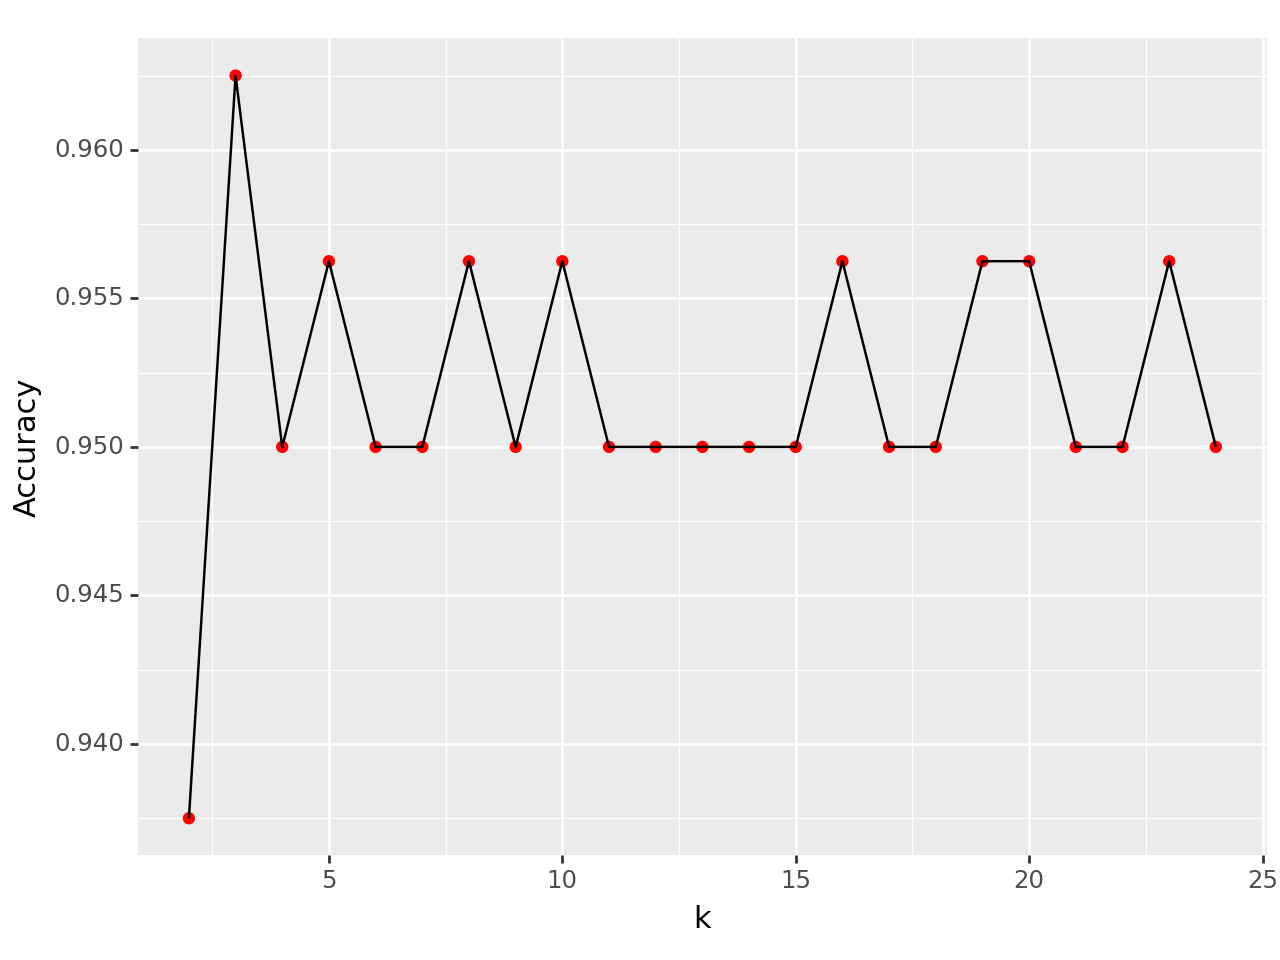

<Figure Size: (640 x 480)>

In [35]:
# Graficamos k vs calificaciones 
(ggplot(aes(range(2, 25), calificaciones))
+ geom_point(color='r')
+ geom_line()
+ labs(x='k', y='Accuracy')
)

Vemos que el máximo valor de 'accuracy' lo obtenemos para $k$=3

In [37]:
# Finalmente dibujamos el arbol con k=3. Para ello primero definimos el modelo
model_tree_best = tree.DecisionTreeClassifier(max_depth=3, class_weight="balanced")
model_tree_best.fit(X, y)
dibujar_arbol(model_tree_best, 'model_tree_best')

<img src='model_tree_best.png'>